# Appendix 3: Contract-Type Segmented Model

We explored building separate models for each `NAME_CONTRACT_TYPE`, which is main types of loans in the dataset
- Cash loans: 90.48%
- Revolving loans: 9.52%

Two models were trained independently on each segment. However, results showed no performance gain
- Cash-loans model: CV AUC = 0.7822
- Revolving-loans model: CV AUC = 0.7545
- Combined model: CV AUC = 0.7814
- Baseline (no segmentation): CV AUC = 0.7828

Despite a slight improvement in the public Kaggle score, the segmented approach did not yield better cross-validation performance and may not generalize well due to the class imbalance.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_columns = None
pd.set_option('display.float_format', '{:.4f}'.format)

In [2]:
data_path = 'home-credit-default-risk/'

## Part 1: Data Preparation

In [3]:
def describe_df(df):
    print(df.shape)
    
    desc = df.describe()
    display(desc)
    
    if desc.shape[1] == df.shape[1]:
        return
    
    desc_o = df.describe(include='object')
    display(desc_o)

    for c in desc_o.columns:
        if df[c].nunique() < 20:
            print(df[c].fillna('-- null --').value_counts(normalize=True))
            print()
            
def clean_columns_name(df, prefix=''):
    return [(prefix+'_'.join(col)).upper().replace(' ', '_') for col in df.columns]

In [4]:
df_app_train = pd.read_csv(data_path + 'application_train.csv')
df_app_test = pd.read_csv(data_path + 'application_test.csv')

In [5]:
df_bureau = pd.read_csv(data_path + 'bureau.csv')
df_bureau_bal = pd.read_csv(data_path + 'bureau_balance.csv')

In [6]:
df_bb_status = (
    df_bureau_bal
    .pivot_table(
        index='SK_ID_BUREAU',
        columns='STATUS',
        values='MONTHS_BALANCE',
        aggfunc='count',
        fill_value=0
    )
    .add_prefix('MONTHS_STATUS_')
)
df_bb_status['MONTHS'] = df_bb_status.sum(axis=1)
print(df_bureau_bal.shape, '-->', df_bb_status.shape)

(27299925, 3) --> (817395, 9)


In [7]:
selected_amt_cols = ['AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_MAX_OVERDUE']
list_credit_active_main = ['Active', 'Closed']

df_bureau.loc[
    df_bureau['CREDIT_ACTIVE'].isin(list_credit_active_main), 'CREDIT_ACTIVE_MAIN'] = df_bureau['CREDIT_ACTIVE']
df_bureau_active = (
    df_bureau
    .merge(df_bb_status, on='SK_ID_BUREAU', how='left')
    .pivot_table(
        index='SK_ID_CURR',
        columns='CREDIT_ACTIVE_MAIN',
        aggfunc={
            'SK_ID_BUREAU': 'count',
            **{c: ['sum', 'max', 'mean'] for c in selected_amt_cols},
            **{c: 'sum' for c in df_bb_status.columns},
        },
        fill_value=0
    )
)
df_bureau_active.columns = clean_columns_name(df_bureau_active, 'BR_')
print(df_bureau.shape, '-->', df_bureau_active.shape)

(1716428, 18) --> (305622, 38)


In [8]:
list_credit_type_main = ['Consumer credit', 'Credit card', 'Car loan', 'Mortgage']
df_bureau.loc[
    df_bureau['CREDIT_TYPE'].isin(list_credit_type_main), 'CREDIT_TYPE_MAIN'] = df_bureau['CREDIT_TYPE']
df_bureau_type = (
    df_bureau
    .pivot_table(
        index='SK_ID_CURR',
        columns='CREDIT_TYPE_MAIN',
        aggfunc={
            'SK_ID_BUREAU': 'count',
            'AMT_CREDIT_SUM': ['sum', 'mean'],
            'AMT_CREDIT_SUM_DEBT': ['sum', 'mean']
        },
        fill_value=0
    )
)
df_bureau_type.columns = clean_columns_name(df_bureau_type, 'BR_TYPE_')
print(df_bureau.shape, '-->', df_bureau_type.shape)

(1716428, 19) --> (305436, 20)


In [9]:
df_prev_app = pd.read_csv(data_path + 'previous_application.csv')
df_pos_bal = pd.read_csv(data_path + 'POS_CASH_balance.csv')
df_credit_bal = pd.read_csv(data_path + 'credit_card_balance.csv')
df_payment = pd.read_csv(data_path + 'installments_payments.csv')

In [10]:
df_pos_agg = (
    df_pos_bal
    .groupby('SK_ID_PREV')
    .agg({
        'MONTHS_BALANCE': 'count',
        'CNT_INSTALMENT': ['max', 'mean', 'min'],
        'SK_DPD_DEF': 'mean',
    })
)
df_pos_agg.columns = clean_columns_name(df_pos_agg, 'POS_')
print(df_pos_bal.shape, '-->', df_pos_agg.shape)

(10001358, 8) --> (936325, 5)


In [11]:
selected_cr_cols = [
    'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT', 
    'AMT_PAYMENT_CURRENT', 'AMT_CREDIT_LIMIT_ACTUAL'
]
df_credit_agg = (
    df_credit_bal
    .groupby('SK_ID_PREV')
    .agg({
        **{c: 'mean' for c in selected_cr_cols},
    })
)
df_credit_agg.columns = clean_columns_name(df_credit_agg, 'CR_')
print(df_credit_bal.shape, '-->', df_credit_agg.shape)

(3840312, 23) --> (104307, 4)


In [12]:
df_payment_number = (
    df_payment
    .groupby(['SK_ID_PREV', 'NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER'])
    .agg({
        'DAYS_INSTALMENT': 'max',
        'DAYS_ENTRY_PAYMENT': 'max',
        'AMT_INSTALMENT': 'max',
        'AMT_PAYMENT': 'sum'
    })
    .reset_index()
)
df_payment_number['AMT_PAYMENT'] = df_payment_number['AMT_PAYMENT'].fillna(0)
df_payment_number['AMT_REMAIN'] = df_payment_number['AMT_INSTALMENT'] - df_payment_number['AMT_PAYMENT']
df_payment_number['DAYS_DELAY'] = (df_payment_number['DAYS_ENTRY_PAYMENT'] - df_payment_number['DAYS_INSTALMENT'])\
                                    .fillna(10000)
df_payment_number['FLAG_DELAY'] = (df_payment_number['DAYS_DELAY'] > 0).astype('int')
df_payment_number['FLAG_UNPAY'] = (df_payment_number['DAYS_ENTRY_PAYMENT'].isnull()).astype('int')

df_payment_agg = (
    df_payment_number
    .groupby('SK_ID_PREV')
    .agg({
        'AMT_REMAIN': ['sum', 'mean', 'max'],
        'DAYS_DELAY': ['sum', 'mean', 'max'],
        'FLAG_DELAY': 'sum',
        'FLAG_UNPAY': 'sum'
    })
)
df_payment_agg.columns = clean_columns_name(df_payment_agg, 'PAY_')
print(df_payment.shape, '-->', df_payment_number.shape, '-->', df_payment_agg.shape)

(13605401, 8) --> (12951918, 11) --> (997752, 8)


In [13]:
df_prev_agg = (
    df_prev_app
    .merge(df_pos_agg, on='SK_ID_PREV', how='left')
    .merge(df_credit_agg, on='SK_ID_PREV', how='left')
    .merge(df_payment_agg, on='SK_ID_PREV', how='left')
)
df_prev_agg['CREDIT_TO_APP'] = df_prev_agg['AMT_CREDIT'] - df_prev_agg['AMT_APPLICATION']
df_prev_agg['PCT_CREDIT_TO_APP'] = df_prev_agg['AMT_CREDIT'] / df_prev_agg['AMT_APPLICATION'] - 1
print(df_prev_app.shape, '-->', df_prev_agg.shape)

(1670214, 37) --> (1670214, 56)


In [14]:
df_prev_type = (
    df_prev_agg
    .pivot_table(
        index='SK_ID_CURR',
        columns='NAME_CONTRACT_TYPE',
        aggfunc={
            'SK_ID_PREV': 'count',
            'AMT_ANNUITY': ['sum', 'max', 'mean'],
            'AMT_APPLICATION': ['sum', 'max', 'mean'],
            'CREDIT_TO_APP': ['max', 'min'],
            'PCT_CREDIT_TO_APP': ['max', 'mean'],
            'RATE_DOWN_PAYMENT': ['max', 'mean'],
            'DAYS_DECISION': ['max', 'min'],
            **{c: 'max' for c in df_prev_agg.columns if '_MAX' in c},
            **{c: 'min' for c in df_prev_agg.columns if '_MIN' in c},
            **{c: 'mean' for c in df_prev_agg.columns if '_MEAN' in c},
            **{c: 'sum' for c in df_prev_agg.columns if '_COUNT' in c},
        },
        fill_value=0
    )
)
df_prev_type.columns = clean_columns_name(df_prev_type, 'PREV_')
print(df_prev_agg.shape, '-->', df_prev_type.shape)

(1670214, 56) --> (338857, 96)


In [15]:
df_prev_status = (
    df_prev_app
    .pivot_table(
        index='SK_ID_CURR',
        columns='NAME_CONTRACT_STATUS',
        aggfunc={
            'SK_ID_PREV': 'count',
            'AMT_ANNUITY': ['sum', 'mean'],
        },
        fill_value=0
    )
)
df_prev_status.columns = clean_columns_name(df_prev_status)
count_cols = [c for c in df_prev_status.columns if 'SK_ID_PREV_COUNT_' in c]
prev_count = df_prev_status[count_cols].sum(axis=1)
for col in count_cols:
    df_prev_status['PCT_'+ col] = df_prev_status[col]/prev_count
df_prev_status = df_prev_status.add_prefix('PREV_STATUS_')
print(df_prev_agg.shape, '-->', df_prev_status.shape)

(1670214, 56) --> (338857, 16)


## Part 2: Feature Engineering

In [16]:
selected_app_cols = [
    'NAME_CONTRACT_TYPE',
    'CODE_GENDER',
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'AMT_ANNUITY',
    'AMT_GOODS_PRICE',
    'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS',
    'REGION_POPULATION_RELATIVE',
    'DAYS_BIRTH',
    'DAYS_EMPLOYED',
    'DAYS_REGISTRATION',
    'DAYS_ID_PUBLISH',
    'OWN_CAR_AGE',
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY',
    'FLAG_WORK_PHONE',
    'FLAG_PHONE',
    'OCCUPATION_TYPE',
    'REGION_RATING_CLIENT',
    'REGION_RATING_CLIENT_W_CITY',
    'WEEKDAY_APPR_PROCESS_START',
    'REG_REGION_NOT_LIVE_REGION',
    'REG_CITY_NOT_LIVE_CITY',
    'ORGANIZATION_TYPE',
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'YEARS_BEGINEXPLUATATION_MEDI',
    'YEARS_BEGINEXPLUATATION_MODE',
    'TOTALAREA_MODE',
    'WALLSMATERIAL_MODE',
    'DEF_30_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE',
    'DAYS_LAST_PHONE_CHANGE',
    'FLAG_DOCUMENT_3',
    'AMT_REQ_CREDIT_BUREAU_MON',
    'AMT_REQ_CREDIT_BUREAU_QRT',
    'AMT_REQ_CREDIT_BUREAU_YEAR'
]

to_fill_zero_cols = [
    'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'OWN_CAR_AGE', 'DAYS_LAST_PHONE_CHANGE',
    ## How many observation of client's social surroundings
    'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
    ## Number of enquiries to Credit Bureau about the client
    'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'
]

In [17]:
def gen_feature(df_raw, to_fill_zero_cols):
    ## combine aggregated features from bureau and previous application related data
    df = (
        df_raw[['SK_ID_CURR'] + selected_app_cols]
        .join(df_bureau_active, on='SK_ID_CURR', how='left')
        .join(df_bureau_type, on='SK_ID_CURR', how='left')
        .join(df_prev_type, on='SK_ID_CURR', how='left')
        .join(df_prev_status, on='SK_ID_CURR', how='left')
    )
    ## add interaction betsween high-impact features
    df['EXT_SOURCE_MAX'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].max(axis=1)
    df['EXT_SOURCE_MIN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].min(axis=1)
    df['EXT_SOURCE_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['EXT_SOURCE_SUM'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].sum(axis=1)

    df['DAYS_EMPLOYED_ZERO'] = df['DAYS_EMPLOYED']
    df.loc[df['DAYS_EMPLOYED'] == 365243, 'DAYS_EMPLOYED_ZERO'] = 0
    df['DAYS_EMPLOYED_RATIO'] = df['DAYS_EMPLOYED_ZERO']/df['DAYS_BIRTH']
    
    df['CREDIT_TO_GOOD'] = df['AMT_CREDIT'] - df['AMT_GOODS_PRICE']
    df['PCT_CREDIT_TO_GOOD'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE'] - 1
    df['CREDIT_TO_INCOME'] = df['AMT_CREDIT'] - df['AMT_INCOME_TOTAL']
    df['PCT_CREDIT_TO_INCOME'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL'] - 1
    df['ANNUITY_TO_CREDIT'] = df['AMT_ANNUITY'] - df['AMT_CREDIT']
    df['PCT_ANNUITY_TO_CREDIT'] = df['AMT_ANNUITY'] / df['AMT_CREDIT'] - 1
    
    df['FLAG_NEW_USER'] = (df['PREV_STATUS_SK_ID_PREV_COUNT_APPROVED'].isnull()).astype('int')
    df['FLAG_NEW_TO_BUREAU'] = (df['BR_MONTHS_SUM_ACTIVE'].isnull()).astype('int')

    ## handle categorical features & missing values
    df_object = df.select_dtypes(include='object')
    df[df_object.columns] = df_object.astype('category')
    df[to_fill_zero_cols] = df_raw[to_fill_zero_cols].fillna(0)
    print(df_raw.shape, '-->', df.shape)
    return df

In [18]:
df_train = gen_feature(df_app_train, to_fill_zero_cols)
df_test = gen_feature(df_app_test, to_fill_zero_cols)

(307511, 122) --> (307511, 225)
(48744, 121) --> (48744, 225)


## Part 3: Model Traning

In [22]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

def prepare_train_test_set(df_train, df_test):
    if 'SK_ID_CURR' in df_train.columns:
        X_train = df_train.drop(['SK_ID_CURR'], axis=1)
        X_test = df_test.drop(['SK_ID_CURR'], axis=1)
    else:
        X_train = df_train.copy()
        X_test = df_test.copy()
    y_train = df_app_train['TARGET']

    ## to handle missing dummy columns 
    to_add_cols = [c for c in X_train.columns if c not in X_test.columns]
    for c in to_add_cols:
        X_test[c] = 0
    X_test = X_test[X_train.columns]
    return X_train, y_train, X_test

def fit_lgb(X_train, y_train, X_test):
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    oof_preds = np.zeros(X_train.shape[0])
    test_preds = np.zeros(X_test.shape[0])
    
    for train_idx, val_idx in folds.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = lgb.LGBMClassifier(
            n_estimators=1000, learning_rate=0.05,
            early_stopping_round=50,
            random_state=123, force_col_wise=True
        )
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric='auc')

        oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]
        test_preds += model.predict_proba(X_test)[:, 1] / folds.n_splits
        
    return model, oof_preds, test_preds

In [31]:
df_train['NAME_CONTRACT_TYPE'].value_counts(normalize=True)

NAME_CONTRACT_TYPE
Cash loans        0.9048
Revolving loans   0.0952
Name: proportion, dtype: float64

In [23]:
X_train, y_train, X_test = prepare_train_test_set(df_train, df_test)

model_cash, oof_preds_cash, test_preds_cash = fit_lgb(
    X_train[X_train['NAME_CONTRACT_TYPE'] == 'Cash loans'], 
    y_train[X_train['NAME_CONTRACT_TYPE'] == 'Cash loans'], 
    X_test[X_test['NAME_CONTRACT_TYPE'] == 'Cash loans']
)

model_rev, oof_preds_rev, test_preds_rev = fit_lgb(
    X_train[X_train['NAME_CONTRACT_TYPE'] == 'Revolving loans'], 
    y_train[X_train['NAME_CONTRACT_TYPE'] == 'Revolving loans'], 
    X_test[X_test['NAME_CONTRACT_TYPE'] == 'Revolving loans']
)

[LightGBM] [Info] Number of positive: 18576, number of negative: 204009
[LightGBM] [Info] Total Bins 33582
[LightGBM] [Info] Number of data points in the train set: 222585, number of used features: 223
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083456 -> initscore=-2.396294
[LightGBM] [Info] Start training from score -2.396294
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[341]	valid_0's auc: 0.776567	valid_0's binary_logloss: 0.246017
[LightGBM] [Info] Number of positive: 18577, number of negative: 204008
[LightGBM] [Info] Total Bins 33613
[LightGBM] [Info] Number of data points in the train set: 222585, number of used features: 223
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083460 -> initscore=-2.396235
[LightGBM] [Info] Start training from score -2.396235
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[431]	valid_0's auc: 0.780893	valid_0's binary_logloss: 0.244733
[Light

In [24]:
df_oof_preds = df_train[['SK_ID_CURR']].copy()
df_oof_preds.loc[df_train['NAME_CONTRACT_TYPE'] == 'Cash loans', 'TARGET'] = oof_preds_cash
df_oof_preds.loc[df_train['NAME_CONTRACT_TYPE'] == 'Revolving loans', 'TARGET'] = oof_preds_rev

print('CV AUC:', roc_auc_score(y_train, df_oof_preds['TARGET']))
print('CV AUC - Cash loans:', roc_auc_score(
    y_train[df_train['NAME_CONTRACT_TYPE'] == 'Cash loans'], 
    df_oof_preds[df_train['NAME_CONTRACT_TYPE'] == 'Cash loans']['TARGET'])
)
print('CV AUC - Revolving loans:', roc_auc_score(
    y_train[df_train['NAME_CONTRACT_TYPE'] == 'Revolving loans'], 
    df_oof_preds[df_train['NAME_CONTRACT_TYPE'] == 'Revolving loans']['TARGET'])
)

CV AUC: 0.7814007365781905
CV AUC - Cash loans: 0.7822255573840197
CV AUC - Revolving loans: 0.7545070025928854


In [25]:
df_submission = df_test[['SK_ID_CURR']].copy()
df_submission.loc[df_test['NAME_CONTRACT_TYPE'] == 'Cash loans', 'TARGET'] = test_preds_cash
df_submission.loc[df_test['NAME_CONTRACT_TYPE'] == 'Revolving loans', 'TARGET'] = test_preds_rev
df_submission.to_csv('prediction_contract_type_segment.csv', index=False)

#### Kaggle scores of contract-type segmented model
- Public: 0.78748
- Private: 0.78048

## Part 4: Model Explaination

In [28]:
import shap
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, average_precision_score,
    roc_auc_score, log_loss, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

def cal_shap(model, X):
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    return shap_values

def cal_top_features(shap_values, X):
    shap_importance = np.abs(shap_values[:, :, 1].values).mean(axis=0)
    features = pd.Series(shap_importance, index=X.columns).sort_values(ascending=False)
    top_features = features[features > 0.01]
    print('# Top features:', len(top_features))
    print(top_features.head(50))
    return features

def get_shap_features(model, X):
    shap_values = cal_shap(model, X)
    features = cal_top_features(shap_values, X)
    return shap_values, features

In [32]:
shap_cash, features_cash = get_shap_features(model_cash, X_train)

# Top features: 82
EXT_SOURCE_MEAN                                    0.4498
PCT_ANNUITY_TO_CREDIT                              0.1131
CODE_GENDER                                        0.0987
ORGANIZATION_TYPE                                  0.0985
EXT_SOURCE_SUM                                     0.0945
AMT_ANNUITY                                        0.0805
PREV_POS_CNT_INSTALMENT_MAX_MAX_CASH_LOANS         0.0709
PREV_PAY_DAYS_DELAY_MAX_MAX_CONSUMER_LOANS         0.0636
PREV_PAY_DAYS_DELAY_MAX_MAX_CASH_LOANS             0.0600
CREDIT_TO_GOOD                                     0.0577
NAME_FAMILY_STATUS                                 0.0549
PCT_CREDIT_TO_GOOD                                 0.0527
NAME_EDUCATION_TYPE                                0.0517
OCCUPATION_TYPE                                    0.0482
BR_TYPE_AMT_CREDIT_SUM_DEBT_MEAN_CREDIT_CARD       0.0480
FLAG_OWN_CAR                                       0.0471
PREV_POS_MONTHS_BALANCE_COUNT_SUM_CASH_LOANS       0.

In [33]:
shap_rev, features_rev = get_shap_features(model_rev, X_train)

# Top features: 54
EXT_SOURCE_MEAN                                    0.4330
EXT_SOURCE_SUM                                     0.1737
ORGANIZATION_TYPE                                  0.1033
CREDIT_TO_INCOME                                   0.1019
NAME_EDUCATION_TYPE                                0.0724
DAYS_EMPLOYED_ZERO                                 0.0655
TOTALAREA_MODE                                     0.0506
OCCUPATION_TYPE                                    0.0471
DAYS_ID_PUBLISH                                    0.0385
EXT_SOURCE_3                                       0.0364
BR_AMT_CREDIT_SUM_MEAN_CLOSED                      0.0339
AMT_CREDIT                                         0.0325
PREV_AMT_ANNUITY_MAX_CONSUMER_LOANS                0.0313
EXT_SOURCE_MIN                                     0.0299
DAYS_BIRTH                                         0.0275
PREV_CREDIT_TO_APP_MIN_CONSUMER_LOANS              0.0272
PREV_AMT_ANNUITY_SUM_CONSUMER_LOANS                0.

In [72]:
df_feature = pd.DataFrame(features_cash, columns=['cash'])
df_feature['revolving'] = features_rev
df_feature['avg'] = df_feature[['cash', 'revolving']].mean(axis=1)
df_feature = df_feature.sort_values('avg').tail(30).reset_index(names='feature')

In [73]:
df_feature.sort_values('avg', ascending=False)

,feature,cash,revolving,avg
29,EXT_SOURCE_MEAN,0.4498,0.4330,0.4414
28,EXT_SOURCE_SUM,0.0945,0.1737,0.1341
27,ORGANIZATION_TYPE,0.0985,0.1033,0.1009
26,NAME_EDUCATION_TYPE,0.0517,0.0724,0.0621
25,CREDIT_TO_INCOME,0.0154,0.1019,0.0586
24,PCT_ANNUITY_TO_CREDIT,0.1131,0.0000,0.0566
23,CODE_GENDER,0.0987,0.0057,0.0522
22,OCCUPATION_TYPE,0.0482,0.0471,0.0476
21,DAYS_EMPLOYED_ZERO,0.0297,0.0655,0.0476
20,PREV_POS_CNT_INSTALMENT_MAX_MAX_CASH_LOANS,0.0709,0.0144,0.0426


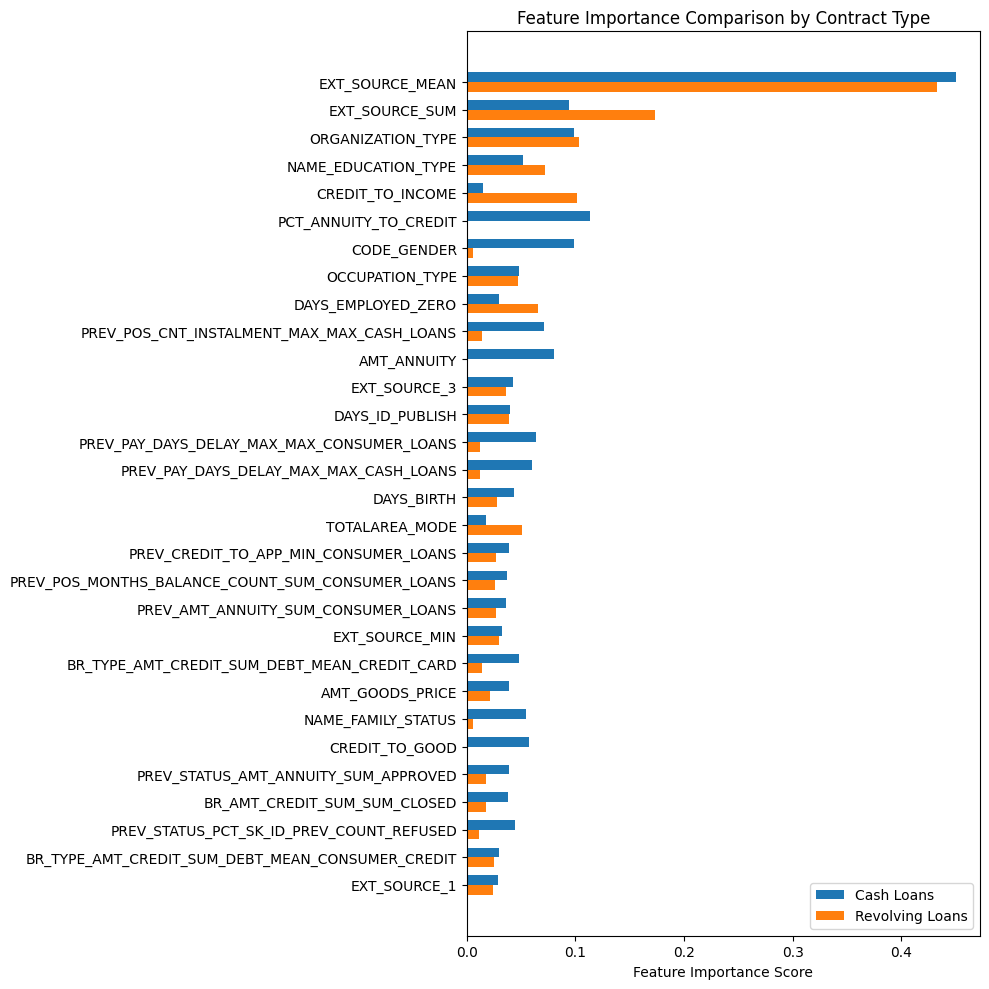

In [75]:
y = np.arange(len(df_feature))
height = 0.35

fig, ax = plt.subplots(figsize=(10, 10))
ax.barh(y + height/2, df_feature['cash'], height, label='Cash Loans')
ax.barh(y - height/2, df_feature['revolving'], height, label='Revolving Loans')

ax.set_yticks(y)
ax.set_yticklabels(df_feature['feature'])
ax.set_xlabel('Feature Importance Score')
ax.set_title('Feature Importance Comparison by Contract Type')
ax.legend()

plt.tight_layout()
plt.show()